In [1]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
from cycler import cycler
import matplotlib as mpl
wandb_id = "" # YOUR WANDB ID
api = wandb.Api()
project = "FedResFinal"
runs = api.runs(f"{wandb_id}/{project}")
all_runs = []
for run in runs:
    if run.State=="finished" and "n_workers" in run.config and run.config["heterogeneity"]=="dir" and run.config["imbalance"] and "lambda/client_0" in run.summary:# and run.config["heterogeneity"]=="mix":
        config = {**run.config}
        for client in tqdm(range(config["n_workers"])):
            run_dict = {}
            for split in ["train", "test"]:
                summary = {**run.summary}
                run_dict = {**run_dict, **config, **summary, "client":client,
                            "lambda":summary[f"lambda/client_{client}"],
                                 f"{split}_loss": summary[f"loss/{split}/client_{client}"],
                                f"{split}_acc": summary[f"accuracy/{split}/client_{client}"],
                                f"slack_{split}":(summary[f"loss/{split}/client_{client}"]-summary[f"loss/{split}/mean"]-config["tolerance_epsilon"]),
                                "run": run.id}
                if f"perturbation/client_{client}" in summary:
                    run_dict["perturbation"] = summary[f"perturbation/client_{client}"]
                    run_dict[f"slack_{split}"] = run_dict[f"slack_{split}"]-summary[f"perturbation/client_{client}"]
                run_dict[f"slack_{split}"] = run_dict[f"slack_{split}"]
            #run_dict["slack_diff"] = 
            all_runs.append(run_dict)
df = pd.DataFrame(all_runs)               

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 798.95it/s]


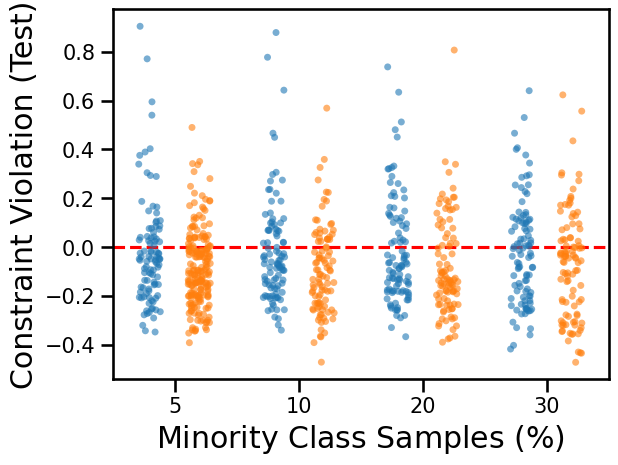

In [38]:
df = df[df["dataset"]=="cifar10"]
mpl.rcParams['lines.linewidth'] = 1.8
sns.set_context("talk", font_scale=1.2)
query_df = df.query("tolerance_epsilon==0.02 and n_minority==3 and reduce_to_ratio>=0.05")
# remove runs with other relaxation penalties
filter_runs = query_df.query("formulation=='imbalance-fl-res' and perturbation_penalty!=1")["run"].to_list()
query_df = query_df[~query_df["run"].isin(filter_runs)]
query_df = query_df.replace({"imbalance-fl": "Constrained", "imbalance-fl-res": "Resilient"})
query_df["Formulation"] =query_df["formulation"]
query_df["reduce_to_ratio"] = 100*query_df["reduce_to_ratio"]
query_df["reduce_to_ratio"] = query_df["reduce_to_ratio"].astype(int)
query_df = query_df.sort_values("Formulation")
ax = sns.stripplot(data=query_df, y="slack_test", x="reduce_to_ratio", hue="Formulation", alpha=0.6, dodge=True, jitter=0.18)
plt.axhline(y=0, color="r", linestyle = 'dashed')
plt.xlabel("Minority Class Samples ($\\%$)")
plt.ylabel("Constraint Violation (Test)")
ax.get_legend().remove()
ax.tick_params(axis="x",  labelsize=15)
ax.tick_params(axis="y",  labelsize=15)
plt.savefig("Violation_frac_minority_strip.pdf",  bbox_inches="tight", dpi=250)
#plt.ylim((0.77, 0.86))

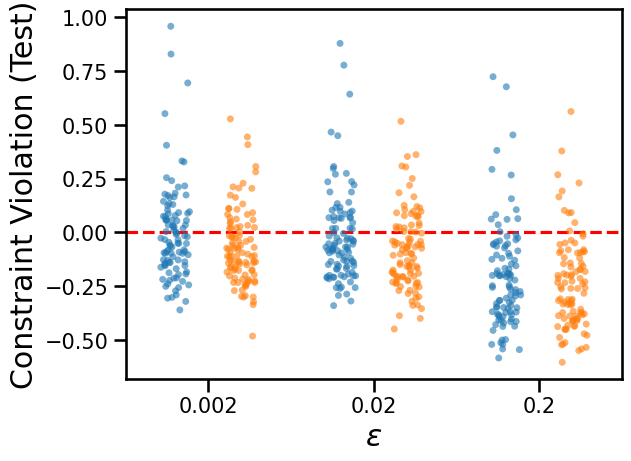

In [34]:
df = df[df["dataset"]=="cifar10"]
query_df = df.query("n_minority==3 and reduce_to_ratio==0.1 and tolerance_epsilon>=0.002")
# remove runs with other relaxation penalties
filter_runs = query_df.query("formulation=='imbalance-fl-res' and perturbation_penalty!=2")["run"].to_list()
query_df = query_df[~query_df["run"].isin(filter_runs)]
query_df = query_df.replace({"imbalance-fl": "Constrained", "imbalance-fl-res": "Resilient"})
query_df["Formulation"] =query_df["formulation"]
query_df = query_df.sort_values("Formulation")
#for exp_id, exp in df.groupby(["dataset", "heterogeneity", "tolerance_epsilon", "dir_level", "perturbation_lr", "perturbation_penalty", "reduce_to_ratio"]):print(f"heterogeneity {exp_id[1]} epsilon {exp_id[2]}, dir {exp_id[3]}, perturbation lr {exp_id[4]}")
ax = sns.stripplot(data=query_df, y="slack_test", x="tolerance_epsilon", hue="Formulation", alpha=0.6, dodge=True, jitter=0.18)
ax.get_legend().remove()
ax.tick_params(axis="x",  labelsize=15)
ax.tick_params(axis="y",  labelsize=15)
plt.axhline(y=0, color="r", linestyle = 'dashed')
plt.xlabel("$\epsilon$")
plt.ylabel("Constraint Violation (Test)")
plt.savefig("Violation_eps_strip.pdf",bbox_inches="tight", dpi=250)


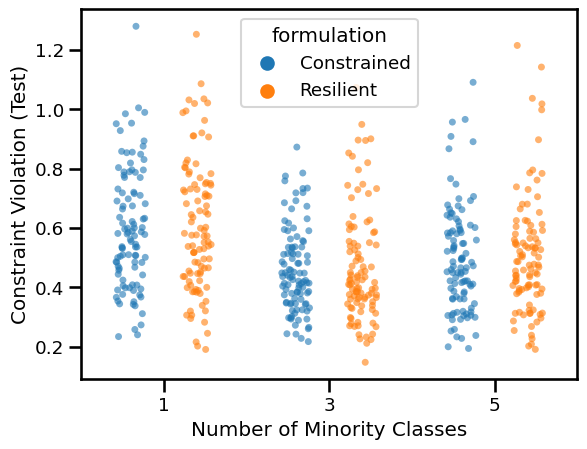

In [31]:
mpl.rcParams['lines.linewidth'] = 1.8
sns.set_context("talk", font_scale=1.2)
df = df[df["dataset"]=="cifar10"]
query_df = df.query("tolerance_epsilon==0.02 and reduce_to_ratio==0.01")
query_df = query_df.replace({"imbalance-fl": "Constrained", "imbalance-fl-res": "Resilient"})
query_df["Formulation"] = query_df["formulation"]
#for exp_id, exp in df.groupby(["dataset", "heterogeneity", "tolerance_epsilon", "dir_level", "perturbation_lr", "perturbation_penalty", "reduce_to_ratio"]):print(f"heterogeneity {exp_id[1]} epsilon {exp_id[2]}, dir {exp_id[3]}, perturbation lr {exp_id[4]}")
sns.stripplot(data=query_df, y="test_loss", x="n_minority", hue="formulation", alpha=0.6, dodge=True, jitter=0.18)
plt.xlabel("Number of Minority Classes")
plt.ylabel("Constraint Violation (Test)")
plt.savefig("Violation_n_minority.pdf",  bbox_inches='tight')
#plt.ylim((0.77, 0.86))